In [19]:
%matplotlib inline

In [20]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
from scipy import signal
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from gwpy.timeseries import TimeSeries

### Firstly - let's open sample hdf5 containing our data

In [21]:
data_dir = os.path.join(os.path.dirname(os.getcwd()),"data") + "/hdf5"
print("Directory containing the data:")
data_dir

Directory containing the data:


'/home/filip/Work/2019BragaSchool-gwhandson-master/data/hdf5'

In [22]:
hdf5_filename = "L1_ZzK9qapmuh_1127563548.0_7.hdf5"
h5=h5py.File(os.path.join(data_dir,hdf5_filename), 'r')

Important info! If the hdf is opened elsewhere, you will get an error saying "Resource temporarily unavailable".

If you want to use it here, you need to close it elsewhere.

The content of the file is the followin:

-  Strain
    -  Strain:
        -  value
        -  attributes:
            1. GPSstart
            2. GPSend
            3. Sample_Rate
            4. Ifo

In [23]:
list(h5.keys())

['Strain']

In [24]:
list(h5["Strain"].keys())

['Strain']

In [25]:
list(h5["Strain"]["Strain"].attrs)

['GPSstart', 'GPSend', 'Sample_Rate', 'Ifo', 'SNR']

Let's print the attributes

In [26]:
GPSstart = h5["Strain"]["Strain"].attrs["GPSstart"]
GPSend = h5["Strain"]["Strain"].attrs["GPSend"]
Sample_Rate = h5["Strain"]["Strain"].attrs["Sample_Rate"]
Ifo = h5["Strain"]["Strain"].attrs["Ifo"]
print ('GPSstart',GPSstart)
print ('GPSend',GPSend)
print ('Sample_Rate',Sample_Rate)
print ('Ifo',Ifo)

GPSstart 1127563548.0
GPSend 1127563552.0
Sample_Rate 4096.0
Ifo b'L1'


Now, let's plot the time-series

In [27]:
strain = h5["Strain"]["Strain"].value
ts = 1./Sample_Rate
half = (GPSend-GPSstart)/2.
time = np.arange(-half,half,ts)

Text(0, 0.5, 'Strain')

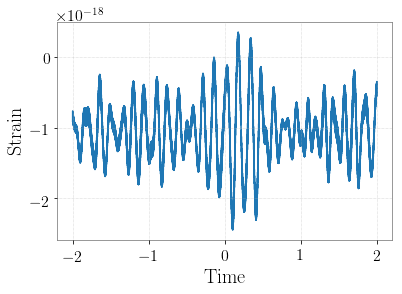

In [28]:
plt.plot(time, strain)
plt.xlabel("Time")
plt.ylabel("Strain")

# Data whitening

Sometimes your data might containg set of random variables that are correlated with each other (with variance different than `1`). This behaviour sometimes might introduce unnecessary problems in the analysis. Thus it is a good approach to apply whitening transformation and remove that correlation. 

To do it, you can use GWpy `whitening` method. Before remember to convert your signal into `TimeSeries` object.

The method requires few parameters. You can find full list under here: https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.whiten

For the sake of this example you need to only specify two parameters:

- fftlength - FFT integration length (in seconds) for ASD estimation

- overlap - number of seconds of overlap between FFTs

In [30]:
strain_gw = TimeSeries(strain)

In [45]:
whitened_strain = strain_gw.whiten(4,2).value

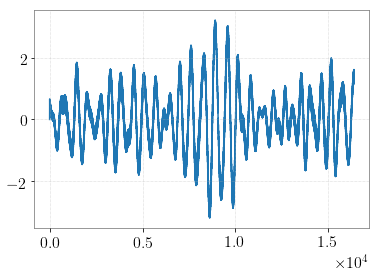

In [47]:
plt.plot(whitened_strain)

# Spectrograms

Basically there are two approaches, you can follow. You can either use Time-Series data or convert the given data to spectrograms.

In the first case, the data are ready to be used. You only need to label them correctly and shuffle. I will show this later.

In the latter case, you have to convert the 1D data to 2D representation . In Python there are already existing libraries able to create spectrograms. I will focus in this tutorial on the scipy package.

But first of all, let's remind ourselves what spectrogram is. A spectrogram is simply a visual representation of the Short-Time Fourier Transform. To create a spectrogram you split your data into chunks and apply Fourier Transform to each of them. As a result of this operation, each chunk has particular width (associated with time) and the frequency distribution (as a result of FT). After processing whole data sample, you combine those distributions from all chunks into one graph - a spectrogram.

Now, few more technical details of how you can make the spectrogram. `spectrogram` function can be find inside `scipy.signal` package. It requires few parameters described below:

- time-series data to be convered into the spectrogram
- fs - sampling frequency of the time-series data
- nperseg - length of chunk of data; the smaller the chunk, the higher time resolution will be
- window - windowing function to be applied on the chunk (most commonly used is `Hann` function)
- noverlap - number of overlapping points between chunks; chunks should overlap to avoid spectral leaking (or reduce its effect on the spectrogram)
- nfft - length of Fast-Fourier-Transform to be applied on the chunk; this parameters defines how many points will be computed for each chunk; a higher number of FFT points would give higher frequency resolution and thus showing fine-grained details along the frequency axis of the spectrogram if visualised.

The method outputs few arrays:
- t - array of segment times
- f - array of sample frequencies
- Sxx - computed spectrogram


In [48]:
k1 = 100/70   # overlap factor - defines the portion of chunk that will be overlapped
f, t, Sxx = signal.spectrogram( whitened_strain
, window='hann',fs=Sample_Rate, nperseg=128, noverlap=128//k1, nfft=512)

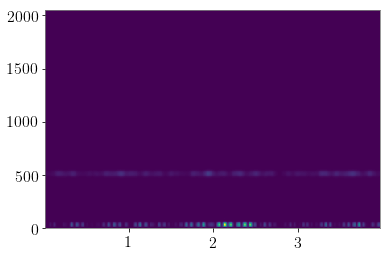

In [49]:
plt.figure()
plt.pcolormesh(t, f, Sxx)

Sometimes it is better to use logarithmic scale for the spectrogram

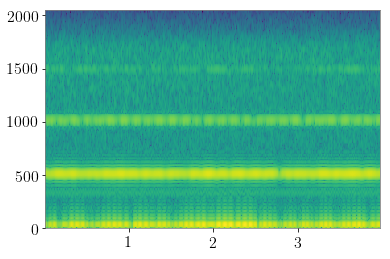

In [50]:
plt.figure()
log_sq_Sxx = np.log(np.sqrt(Sxx))
plt.pcolormesh(t, f, log_sq_Sxx)

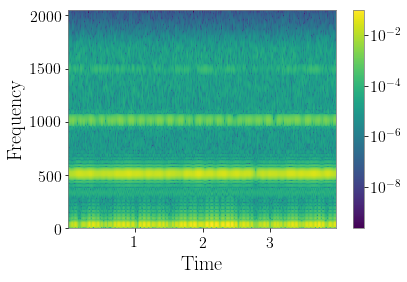

In [51]:
# Let's also add some colorbar to introduce description of what we can see
plt.figure()
log_sq_Sxx = np.log(np.sqrt(Sxx))
plt.pcolormesh(t, f, log_sq_Sxx)
v1, v2 = np.sqrt(Sxx.min()), np.sqrt(Sxx.max())
Log10scale=LogNorm(vmin=v1, vmax=v2)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.pcolor(t, f, log_sq_Sxx, norm=Log10scale)
plt.colorbar();

`Sxx` will be your input data for ML if you decide to follow this approach

# Data preprocessing

Once your data is created, you need to apply some preprocessing to it. 

First of all, you need to scale the data into the proper range. It depends on your algorithm, but usually you should scale the data to the range [0, 1] or [-1, 1].

You can either manually code proper formula or use one of the exisiting ones. As an example, let me present you the `sklearn.preprocessing` package. There you can find few usefull functions:

-  maxabs_scale - converts the data into the range [-1, 1]

-  minmax_scale - converts the data into the range [0, 1]

Important note! Those functions require 2D data. In case of set containing thousands of images we will have 3D array: (n_samples, width, height). So we need to reshape our data, apply the scaler, and reshape once more.

In [14]:
# Let's make artificial dataset
data = np.zeros((1000, log_sq_Sxx.shape[0], log_sq_Sxx.shape[1]))
data[:] = log_sq_Sxx
n_samples, width, height = data.shape[0], data.shape[1], data.shape[2]

In [15]:
# Let's now rescale the data to the range [0, 1]
data = np.reshape(data, (n_samples, width*height))
rescaled_data = preprocessing.minmax_scale(data.T).T
rescaled_data = np.reshape(rescaled_data, (n_samples, width, height))

In [16]:
print("Min value: %s" %(rescaled_data[0].min()))
print("Max value: %s" %(rescaled_data[0].max()))

Min value: 0.0
Max value: 1.0


After rescaling, we can shuffle the data. For many ML algorithms this step is very important. Unshuffled data might lead to poor training.

One of the fastest ways to shuffle the data is the `permutation` function of `numpy` package.

In [17]:
ind = np.random.permutation(rescaled_data.shape[0])
rescaled_data = np.take(rescaled_data, ind, axis=0)

`permutation` is fast and can also be applied to labels if we are dealing with supervised learning.

In [18]:
# Let's simulate labels - 3 classes
labels = np.random.randint(0, 3, rescaled_data.shape[0])
labels = np.take(labels, ind)

In case of more than 2 labels, very often we have to convert them to one-hot encoded version e.g for 3 classes:

0 -> [1, 0, 0]

1 -> [0, 1, 0]

2 -> [0, 0, 1]

`sklearn` also provides us with the solution to this problem.

In [19]:
onehot_encoder = OneHotEncoder(sparse=False)
labels = labels.reshape(labels.shape[0], 1)
targets = onehot_encoder.fit_transform(labels)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Data augmentation

Sometimes you don't have enough data. Or you have a lot of data but you would like to create more diversed dataset.

There are ways of doing this. Whole process of creating artificial data is called data augmentation. Here I present you few examples you could use in your work.

Let's start from time-series data. There are 2 basic functions you can use:

-  add noise
-  shift

In [20]:
def add_noise(data):
    output_data = []
    for sample in data:
        noise = np.random.randn(len(sample))
        data_noise = sample + 0.05 * noise
        output_data.append(data_noise)
    output_data = np.vstack(output_data)
    return output_data

In [21]:
def shift(data):
    output_data = []
    for sample in data:
        output_data.append(np.roll(sample, 1500))
    output_data = np.vstack(output_data)
    return output_data

Let's try them on our waveforms. Both methods assume we have a set of waveforms. But first of all, let's apply some preprocessing.

In [22]:
# Let's make artificial dataset
data_wv = np.zeros((1000, strain.shape[0]))
data_wv[:] = strain
n_wv, length = data_wv.shape[0], data_wv.shape[1]

In [23]:
# Let's now rescale the data to the range [0, 1]
rescaled_data_wv = preprocessing.minmax_scale(data_wv.T).T

In [24]:
noised_strain_wv = add_noise(rescaled_data_wv)
shifted_strain_wv = shift(rescaled_data_wv)

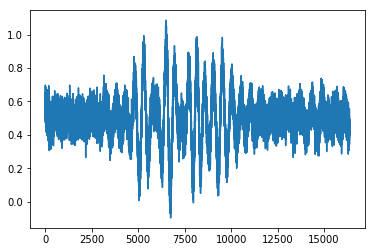

In [25]:
plt.plot(noised_strain_wv[0])

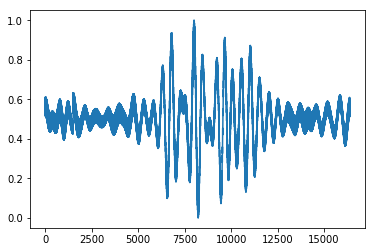

In [26]:
plt.plot(shifted_strain_wv[0])

Now, let's move to images. Here I give you 4 functions that you could apply:

-  add noise
-  flip
-  translate


In [27]:
def add_noise_2d(data):
    output_data = []
    for sample in data:
        noise = np.random.randn(sample.shape[0]*sample.shape[1])
        noise = np.reshape(noise, (sample.shape[0], sample.shape[1]))
        data_noise = sample + 0.05 * noise
        output_data.append(data_noise)
    output_data = np.array(output_data)
    return output_data

In [28]:
def flip_2d(data):
    output_data = []
    for sample in data:
        flipped = np.fliplr(sample)
        output_data.append(flipped)
    output_data = np.array(output_data)
    return output_data

In [29]:
def translate_2d(data):
    
    output_data = []
    for sample in data:
        translation_type = np.random.randint(0,2, 1)
        
        # Translate to the right
        if translation_type == 0:
            translation = np.roll(sample, (0, 100))
        # Translation to the left
        else:
            translation = np.roll(sample, (0, -100))
        output_data.append(translation)
    output_data = np.array(output_data)
    return output_data


In [30]:
noised_data = add_noise_2d(rescaled_data)
flipped_data = flip_2d(rescaled_data)
translated_data = translate_2d(rescaled_data)

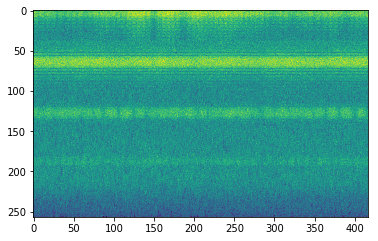

In [31]:
plt.imshow(noised_data[0])

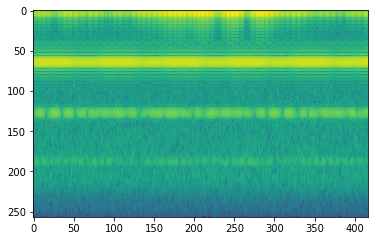

In [32]:
plt.imshow(flipped_data[0])

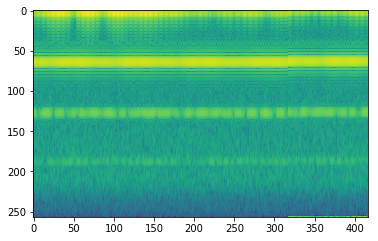

In [33]:
plt.imshow(translated_data[0])

Don't forget to close hdf5 file!

In [34]:
h5.close()